In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from config import get_default_cfg
from sae import VanillaSAE, TopKSAE, BatchTopKSAE, JumpReLUSAE
import transformer_lens
from transformer_lens import HookedTransformer, HookedEncoder
from transformers import GPT2Tokenizer, GPT2Model, BertModel, BertTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from sentence_transformers import SentenceTransformer
import heapq
from tqdm import tqdm
import random
import subprocess
import time

In [3]:
def get_gpu_temperature(gpu_id=0):
    try:
        output = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=temperature.gpu", "--format=csv,noheader,nounits", f"--id={gpu_id}"],
            encoding="utf-8"
        )
        return int(output.strip())
    except Exception as e:
        print(f"[WARN] Could not read GPU temperature: {e}")
        return None

def wait_for_gpu_cooling(threshold=77, resume_temp=65, gpu_id=0, check_interval=10):
    while True:
        temp = get_gpu_temperature(gpu_id)
        if temp is None:
            break
        if temp <= threshold:
            break
        print(f"[INFO] GPU temperature is {temp}°C (waiting untill it reaches {resume_temp}°C)...")
        while temp > resume_temp:
            time.sleep(check_interval)
            temp = get_gpu_temperature(gpu_id)
        print(f"[INFO] GPU cooled down to {temp}°C. Resuming process.")

from transformers import pipeline
from sae import JumpReLUSAE

sbert = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')
distilbert = pipeline("fill-mask", model="distilbert/distilbert-base-cased")
cfg = get_default_cfg()

run = wandb.init()
artifact = run.use_artifact('ybiku-unir/SBERT-SAEs-ThePile/sentence-transformers_paraphrase-mpnet-base-v2_blocks.0.hook_embed_2304_jumprelu_16_0.0003_389:v0', type='model')
artifact_dir = artifact.download()
config_path = os.path.join(artifact_dir, 'config.json')
with open(config_path, 'r') as f:
    config = json.load(f)

if "dtype" in config and isinstance(config["dtype"], str):
    if config["dtype"] == "torch.float32":
        config["dtype"] = torch.float32
    elif config["dtype"] == "torch.float16":
        config["dtype"] = torch.float16

sae = JumpReLUSAE(config).to(config["device"])
sae.load_state_dict(torch.load(os.path.join(artifact_dir, 'sae.pt')))
sae.eval()

Device set to use cuda:0
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ybiku (ybiku-unir) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   2 of 2 files downloaded.  


JumpReLUSAE(
  (jumprelu): JumpReLU()
)

In [5]:
# Calcular el número total de parámetros del SAE
total_params = sum(p.numel() for p in sae.parameters())
total_params

3544320

---
### $W_{dec}$ analysis

In [3]:
W_dec = sae.W_dec.data
W_dec = W_dec.cpu().numpy()
W_dec.shape

(2304, 768)

In [5]:
Wn = W_dec / np.linalg.norm(W_dec, axis=1, keepdims=True)
cos = Wn @ Wn.T
np.fill_diagonal(cos, 0)
max_overlap = cos.max()
rank = np.linalg.matrix_rank(W_dec)

print(f"Real rank: {rank} / 2304")
print(f"Max cosine similarity between features: {max_overlap:.3f}")

Real rank: 768 / 2304
Max cosine similarity between features: 0.208


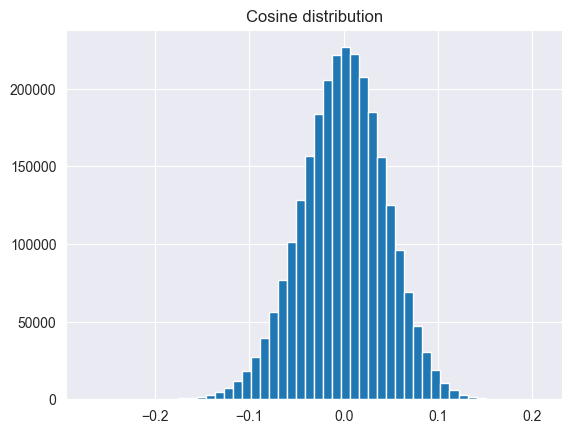

In [6]:
tri = cos[np.triu_indices_from(cos, k=1)]
plt.hist(tri, bins=50); plt.title("Cosine distribution"); plt.show()

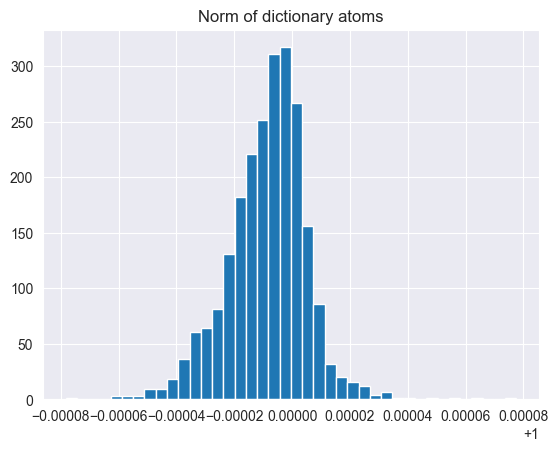

In [9]:
norms = np.linalg.norm(W_dec, axis=1)
plt.hist(norms, bins=40); plt.title("Norm of dictionary atoms"); plt.show()

---
## Analysis of the clusters

In [10]:
import json

with open("feature_keywords_csLG.json", "r", encoding="utf-8") as f:
    all_keywords_results = json.load(f)

with open("top_activations_csLG.json", "r", encoding="utf-8") as f:
    top_activations = json.load(f)

In [11]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import DBSCAN
from collections import defaultdict
from math import log
import numpy as np
import torch

# Parámetros
TOP_K = 5
SIMILARITY_THRESHOLD = 0.9
MERGE_THRESHOLD = 0.9
MIN_FEATURES_PER_CLUSTER = 5  # ← aquí defines el mínimo

# Modelo
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Listas para almacenar embeddings y sus IDs
feature_ids = []
feature_embeddings = []
feature_id_to_keywords = {}

# Paso 1: Representar cada feature como la media ponderada de sus top K keywords
for entry in all_keywords_results:
    feature_id = entry["feature_id"]
    keywords = entry["keywords"][:TOP_K]
    if not keywords:
        continue

    words = [kw for kw, _ in keywords]
    embeddings = embedding_model.encode(words, convert_to_tensor=True)
    device = embeddings.device
    weights = torch.tensor([score for _, score in keywords], dtype=torch.float32, device=device)
    weighted_avg = torch.sum(embeddings * weights[:, None], dim=0) / weights.sum()

    feature_ids.append(feature_id)
    feature_embeddings.append(weighted_avg)
    feature_id_to_keywords[feature_id] = entry["keywords"]

# Paso 2: Matriz de embeddings
feature_embeddings = np.stack([emb.cpu().numpy() for emb in feature_embeddings])

# Paso 3: Clustering con DBSCAN
clustering = DBSCAN(eps=1 - SIMILARITY_THRESHOLD, min_samples=1, metric="cosine")
labels = clustering.fit_predict(feature_embeddings)

# Paso 4: Agrupar por etiqueta
clusters = defaultdict(list)
for idx, label in enumerate(labels):
    clusters[label].append(feature_ids[idx])

# Paso 5: Filtrar clusters con al menos 2 features
clusters_with_multiple = {cid: feats for cid, feats in clusters.items() if len(feats) > 1}

# Paso 6: Calcular la keyword más representativa para cada cluster
cluster_representatives = {}
for cid, feats in clusters_with_multiple.items():
    keyword_scores = defaultdict(float)
    keyword_counts = defaultdict(int)

    for fid in feats:
        for kw, score in feature_id_to_keywords[fid][:TOP_K]:
            keyword_scores[kw] += score
            keyword_counts[kw] += 1

    combined_scores = {
        kw: (keyword_scores[kw] / keyword_counts[kw]) * log(1 + keyword_counts[kw])
        for kw in keyword_scores
    }
    representative = max(combined_scores.items(), key=lambda x: x[1])[0]
    cluster_representatives[representative] = feats

# Paso 7: Agrupar clusters con keywords representativas similares
keywords = list(cluster_representatives.keys())
keyword_embeddings = embedding_model.encode(keywords, convert_to_tensor=True)

merged_clusters = {}
used = set()

for i in range(len(keywords)):
    if i in used:
        continue
    base_kw = keywords[i]
    base_feats = list(cluster_representatives[base_kw])
    for j in range(i + 1, len(keywords)):
        if j in used:
            continue
        sim = util.cos_sim(keyword_embeddings[i], keyword_embeddings[j]).item()
        if sim >= MERGE_THRESHOLD:
            base_feats.extend(cluster_representatives[keywords[j]])
            used.add(j)

    # Nuevo filtro: solo agregamos si hay suficientes features
    if len(base_feats) >= MIN_FEATURES_PER_CLUSTER:
        merged_clusters[base_kw] = base_feats

In [17]:
merged_clusters.keys()

dict_keys(['embedding', 'sparse', 'adversarial', 'bandit', 'fairness', 'variational', 'coronavirus', 'gans generative', 'quantum', 'forgetting', 'spiking neural'])

In [18]:
merged_clusters["sparse"]

[69, 1291, 1345, 1484, 1574]

Intra‑cluster cosines:  n=2333944  mean=-0.0002  std=0.0450
Inter‑cluster cosines:  n=319112  mean=-0.0002  std=0.0448


C:\Users\Diego\AppData\Local\Temp\ipykernel_5320\690181575.py:49: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
D:\Escritorio\PythonProyects\SparseAutoencodersTFM\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


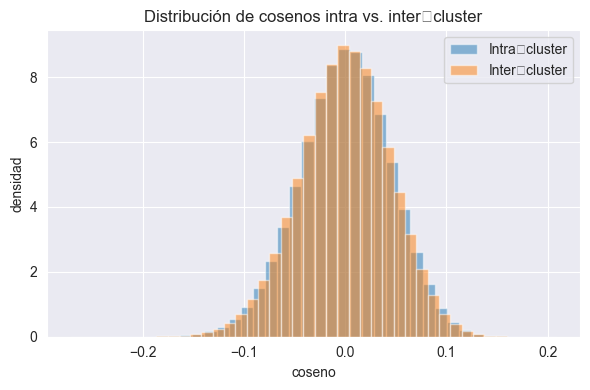

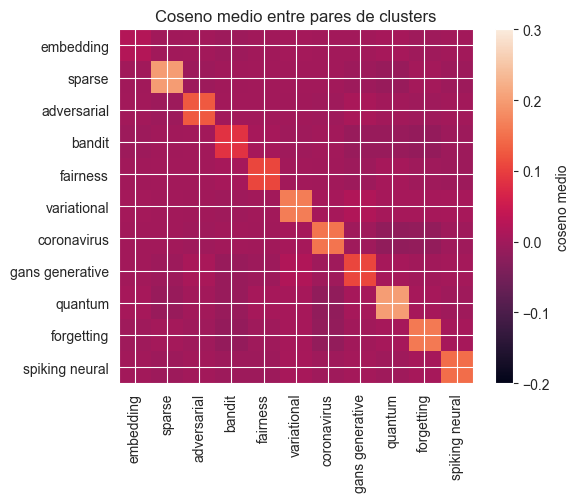

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# ---------- Helper: gracefully check that needed objects exist ----------
needed_vars = ["Wn", "merged_clusters"]
missing = [v for v in needed_vars if v not in globals()]
if missing:
    raise NameError(f"Las variables {missing} no existen en el entorno de Python. "
                    "Asegúrate de haberlas definido antes de ejecutar este bloque.")

# Normalised dictionary (2304, 768)
W = Wn.copy()   # alias

# ------------- Build mappings -------------
cluster_ids = list(merged_clusters.keys())
cluster_of_feature = {}
for cid in cluster_ids:
    for idx in merged_clusters[cid]:
        cluster_of_feature[idx] = cid

# ------------- Compute intra / inter cosine lists -------------
intra = []
inter = []

for i, j in combinations(range(W.shape[0]), 2):
    cos_ij = float(np.dot(W[i], W[j]))  # cosine because vectors are unit‑normed
    if cluster_of_feature.get(i) == cluster_of_feature.get(j):
        intra.append(cos_ij)
    else:
        inter.append(cos_ij)

intra = np.array(intra)
inter = np.array(inter)

# ------------- Print basic stats -------------
print(f"Intra‑cluster cosines:  n={len(intra)}  mean={intra.mean():.4f}  std={intra.std():.4f}")
print(f"Inter‑cluster cosines:  n={len(inter)}  mean={inter.mean():.4f}  std={inter.std():.4f}")

# ------------- Histogram -------------
plt.figure(figsize=(6,4))
plt.hist(intra, bins=40, alpha=0.5, label='Intra‑cluster', density=True)
plt.hist(inter, bins=40, alpha=0.5, label='Inter‑cluster', density=True)
plt.legend()
plt.title("Distribución de cosenos intra vs. inter‑cluster")
plt.xlabel("coseno")
plt.ylabel("densidad")
plt.tight_layout()
plt.show()

# ------------- Heatmap of mean cosine per cluster pair -------------
K = len(cluster_ids)
heat = np.zeros((K, K))

for a, cid_a in enumerate(cluster_ids):
    for b, cid_b in enumerate(cluster_ids):
        feats_a = merged_clusters[cid_a]
        feats_b = merged_clusters[cid_b]
        heat[a, b] = (W[feats_a] @ W[feats_b].T).mean()

plt.figure(figsize=(6,5))
plt.imshow(heat, vmin=-0.2, vmax=0.3)
plt.colorbar(label="coseno medio")
plt.xticks(range(K), cluster_ids, rotation=90)
plt.yticks(range(K), cluster_ids)
plt.title("Coseno medio entre pares de clusters")
plt.tight_layout()
plt.show()


In [21]:
for cid, feats in merged_clusters.items(): print(cid, (Wn[feats] @ Wn[feats].T).mean())

embedding 0.022264974
sparse 0.19895953
adversarial 0.12651986
bandit 0.086101584
fairness 0.10746267
variational 0.16522275
coronavirus 0.15489957
gans generative 0.108525224
quantum 0.20175976
forgetting 0.16000003
spiking neural 0.14761111
